In [48]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS
c:\Dev\MinorProject\WDSS


In [49]:
import torch

from config import Settings, device
from commons import initialize
from utils.image_utils import ImageUtils
from network.losses import ImageEvaluator
from utils import *

In [50]:
settings = Settings('config/config.json', 'TEST')
initialize(settings)

Job: pp_combined, Model: TEST, Device: cuda
Model path: out\pp_combined-TEST\model
Log path: out\pp_combined-TEST\logs


In [51]:
from network.dataset import *

# Load the dataset
train, val, test = WDSSDatasetCompressed.get_datasets(settings)
print(len(train), len(val), len(test))

600 480 480


In [52]:
from network.dataset import *
from utils.masks import Mask

In [53]:
def normalize_hdr(hdr_image, exposure=1.0):
    return 1.0 - torch.exp(-hdr_image * exposure)

def denomalize_hdr(hdr_image, exposure=1.0):
    return -torch.log(1.0 - hdr_image) / exposure

def aces_tonemap(image):
    A = 2.51
    B = 0.03
    C = 2.43
    D = 0.59
    E = 0.14
    return (image * (A * image + B)) / (image * (C * image + D) + E)

def linear_to_srgb(x):
    return torch.where(x <= 0.0031308, 12.92 * x, 1.055 * (x ** (1/2.4)) - 0.055)

def srgb_to_linear(x):
    return torch.where(x <= 0.04045, x / 12.92, ((x + 0.055) / 1.055) ** 2.4)


In [54]:
def compute_luminance(image: torch.Tensor) -> torch.Tensor:
    r, g, b = image[0:1, :, :], image[1:2, :, :], image[2:3, :, :]
    return 0.2126 * r + 0.7152 * g + 0.0722 * b

def compute_exposure(image: torch.Tensor, percentile: float = 0.5) -> torch.Tensor:
    luminance = compute_luminance(image)
    histogram, bin_edges = torch.histogram(luminance, bins=256, range=(0.0, 1.0))
    cumulative_histogram = torch.cumsum(histogram, dim=0)
    total_pixels = cumulative_histogram[-1]
    threshold = total_pixels * percentile
    bin_index = torch.searchsorted(cumulative_histogram, threshold)
    mean_luminance = bin_edges[bin_index]
    return 0.18 / (mean_luminance * (1.0 - 0.18))

def normalize_hdr_frame(image: torch.Tensor, exposure: torch.Tensor) -> torch.Tensor:
    return image / (exposure + 1e-6)

def denormalize_hdr_frame(image: torch.Tensor, exposure: torch.Tensor) -> torch.Tensor:
    return image * (exposure + 1e-6)

In [55]:
def brdf_demodulate(
    frame: torch.Tensor,
    brdf_map: torch.Tensor
) -> torch.Tensor:
    """Demodulate the frame using the BRDF map.
    """
    demodulated_frame = torch.where(brdf_map == 0, 0, frame / brdf_map)
    # demodulated_frame = frame / brdf_map

    return demodulated_frame

def brdf_remodulate(
    frame: torch.Tensor,
    brdf_map: torch.Tensor
) -> torch.Tensor:
    """Remodulate the frame using the BRDF map.
    """
    remodulated_frame = torch.where(brdf_map == 0, 0, frame * brdf_map)
    # remodulated_frame = frame * brdf_map

    return remodulated_frame


In [56]:
def compute_brdf(
    diffuse: torch.Tensor,
    roughness: torch.Tensor,
    metallic: torch.Tensor,
    specular: torch.Tensor,
    NoV: torch.Tensor,
    precomp: torch.Tensor
) -> torch.Tensor:
    """Demodulate the frame using the BRDF parameters.
    """
    nov_idx = (NoV * 511).long().clamp(0, 511)
    roughness_idx = (roughness * 511).long().clamp(0, 511)

    # Sample the pre-conputed BRDF lookup table
    pre_integration = precomp[0][nov_idx, roughness_idx]
    pre_integration_b = precomp[1][nov_idx, roughness_idx]

    # Compute specular reflactange
    specular = specular.expand(3, -1, -1)
    metallic = metallic.expand(3, -1, -1)

    # Compute the specular reflectance
    specular_color = torch.lerp(0.08 * specular, diffuse, metallic)

    # Calculate the BRDF
    brdf = diffuse * (1 - metallic) + pre_integration * specular_color + pre_integration_b.expand(3, -1, -1)
    # brdf[diffuse == 0] = 0
    return brdf


In [57]:
def compute_brdf_extranet(
    base_color: torch.Tensor,
    specular: torch.Tensor,
    metallic: torch.Tensor,
) -> torch.Tensor:
    brdf = base_color + (1 - metallic) * 0.08 * specular
    return brdf

In [58]:
frame_no = 320
raw_frames = test._get_raw_frames(frame_no=frame_no, no_patch=True)

# Load the precomputed BRDF lookup table
precomp = ImageUtils.opencv_image_to_tensor(ImageUtils.load_exr_image_opencv('res/Precomputed.exr')).squeeze(0)

tensor(0.0063) tensor(3.8965)
tensor(0.0062) tensor(3.8359)


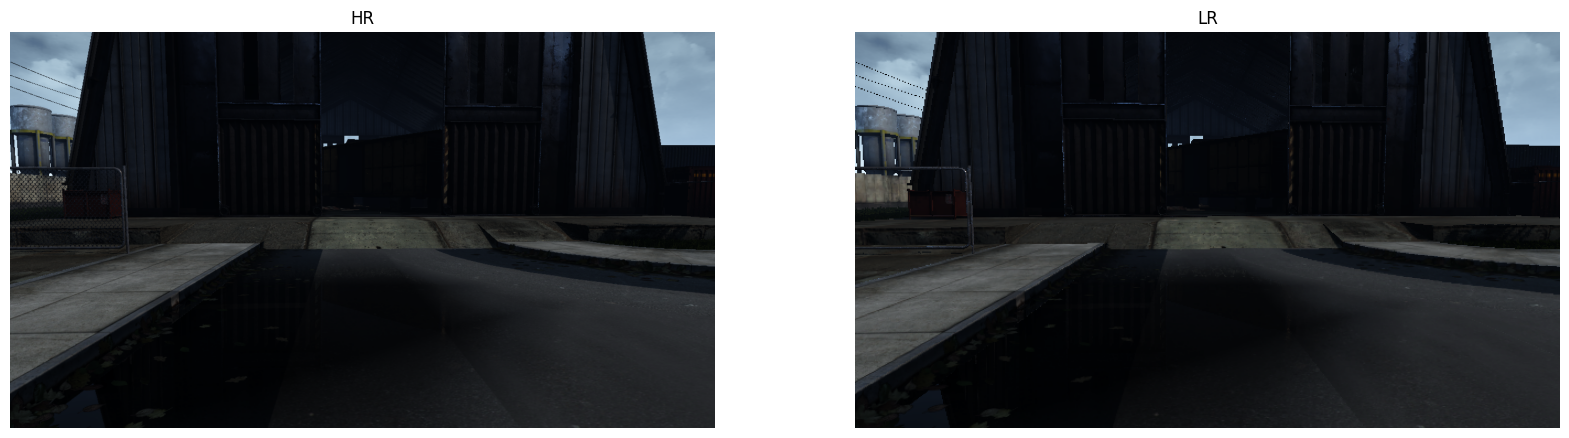

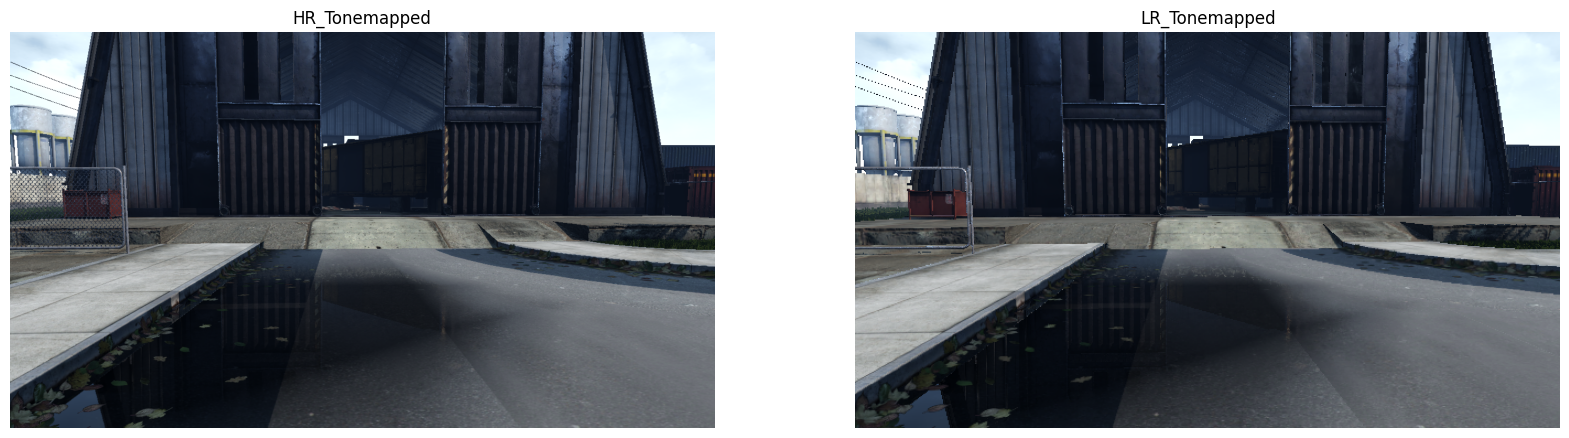

In [59]:
exp = BaseImageNormalizer.from_config({'type': 'exponential'})
tonemapper = BaseTonemapper.from_name('Hable-10')

pre_tonemapped_hr: torch.Tensor = raw_frames[RawFrameGroup.HR_GB][GB_Type.PRE_TONEMAPPED]
pre_tonemapped_lr: torch.Tensor = raw_frames[RawFrameGroup.LR_GB][GB_Type.PRE_TONEMAPPED]

print(pre_tonemapped_hr.min(), pre_tonemapped_hr.max())
print(pre_tonemapped_lr.min(), pre_tonemapped_lr.max())

pre_tonemapped_hr_exp = exp.normalize(pre_tonemapped_hr)
pre_tonemapped_lr_exp = exp.normalize(pre_tonemapped_lr)

tonemapped_hr: torch.Tensor = tonemapper(pre_tonemapped_hr)
tonemapped_lr: torch.Tensor = tonemapper(pre_tonemapped_lr)

# Display the pre-tonemapped HDR image
ImageUtils.display_images([pre_tonemapped_hr_exp, pre_tonemapped_lr_exp], ['HR', 'LR'])
ImageUtils.display_images([tonemapped_hr, tonemapped_lr], ['HR_Tonemapped', 'LR_Tonemapped'])

In [60]:
# tonemapped_lr_up = ImageUtils.upsample(tonemapped_lr.unsqueeze(0), 2.0).squeeze(0)
# pre_tonemapped_lr_up = ImageUtils.upsample(pre_tonemapped_lr_exp.unsqueeze(0), 2.0).squeeze(0)

# # Compute scores
# psnr_tm = ImageEvaluator.psnr(tonemapped_hr, tonemapped_lr_up, 1.0)
# ssim_tm = ImageEvaluator.ssim(tonemapped_hr.unsqueeze(0), tonemapped_lr_up.unsqueeze(0))
# mse_tm = ImageEvaluator.mse(tonemapped_hr, tonemapped_lr_up)
# lpips_tm = ImageEvaluator.lpips(tonemapped_hr, tonemapped_lr_up)

# psnr_ptm = ImageEvaluator.psnr(tonemapped_hr, tonemapper(pre_tonemapped_lr_up), 1.0)
# ssim_ptm = ImageEvaluator.ssim(tonemapped_hr.unsqueeze(0), tonemapper(pre_tonemapped_lr_up).unsqueeze(0))
# mse_ptm = ImageEvaluator.mse(tonemapped_hr, tonemapper(pre_tonemapped_lr_up))
# lpips_ptm = ImageEvaluator.lpips(tonemapped_hr, tonemapper(pre_tonemapped_lr_up))

# # Display the scores
# print(f'Metric,  Tonemapped,  Pre-Tonemapped')
# print(f'PSNR,    {psnr_tm.item():.2f},  {psnr_ptm.item():.2f}')
# print(f'SSIM,    {ssim_tm.item():.4f},  {ssim_ptm.item():.4f}')
# print(f'MSE,     {mse_tm.item():.4f},  {mse_ptm.item():.4f}')
# print(f'LPIPS,   {lpips_tm.item():.4f},  {lpips_ptm.item():.4f}')

In [61]:
hr_albedo = raw_frames[RawFrameGroup.HR_GB][GB_Type.DIFFUSE_COLOR]
lr_albedo = raw_frames[RawFrameGroup.LR_GB][GB_Type.DIFFUSE_COLOR]
hr_base_color = raw_frames[RawFrameGroup.HR_GB][GB_Type.BASE_COLOR]
lr_base_color = raw_frames[RawFrameGroup.LR_GB][GB_Type.BASE_COLOR]
hr_normal = raw_frames[RawFrameGroup.HR_GB][GB_Type.NORMAL]
lr_normal = raw_frames[RawFrameGroup.LR_GB][GB_Type.NORMAL]
hr_roughness = raw_frames[RawFrameGroup.HR_GB][GB_Type.METALLIC_ROUGHNESS_SPECULAR][1:2, :, :]
lr_roughness = raw_frames[RawFrameGroup.LR_GB][GB_Type.METALLIC_ROUGHNESS_SPECULAR][1:2, :, :]
hr_metallic = raw_frames[RawFrameGroup.HR_GB][GB_Type.METALLIC_ROUGHNESS_SPECULAR][0:1, :, :]
lr_metallic = raw_frames[RawFrameGroup.LR_GB][GB_Type.METALLIC_ROUGHNESS_SPECULAR][0:1, :, :]
hr_specular = raw_frames[RawFrameGroup.HR_GB][GB_Type.METALLIC_ROUGHNESS_SPECULAR][2:3, :, :]
lr_specular = raw_frames[RawFrameGroup.LR_GB][GB_Type.METALLIC_ROUGHNESS_SPECULAR][2:3, :, :]
hr_nov = raw_frames[RawFrameGroup.HR_GB][GB_Type.NoV_Depth][0:1, :, :]
lr_nov = raw_frames[RawFrameGroup.LR_GB][GB_Type.NoV_Depth][0:1, :, :]

tensor(0.) tensor(0.7383)
tensor(0.) tensor(0.7383)
Metric,  Albedo
MSE,     0.0000
LPIPS,   0.0000
PSNR,    86.18


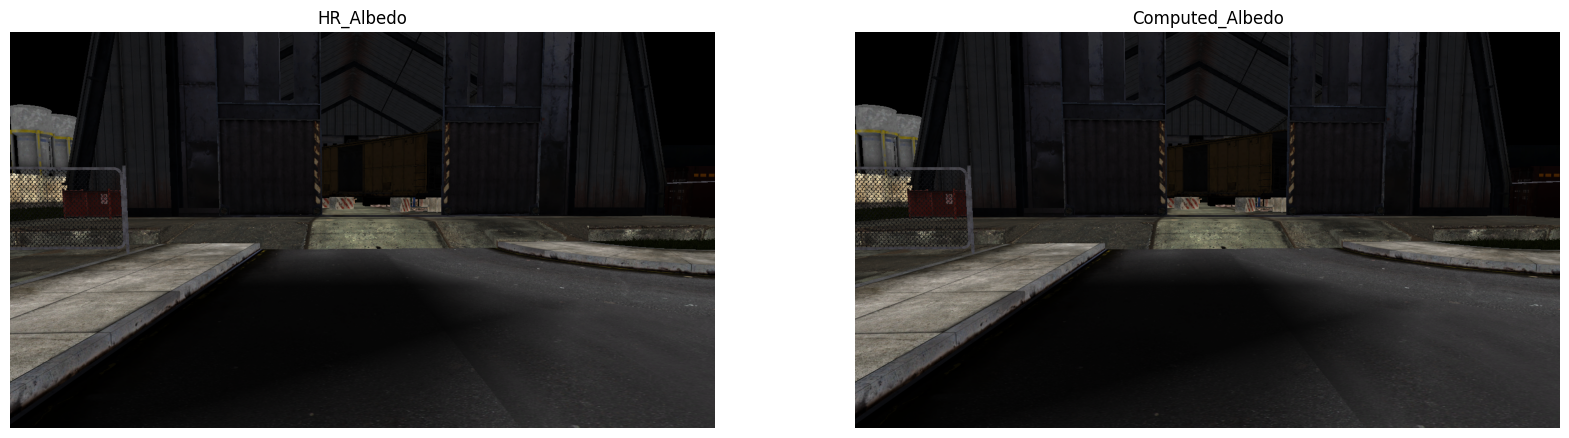

In [62]:
albedo_computed_hr = hr_base_color - hr_base_color * hr_metallic
albedo_computed_lr = lr_base_color - lr_base_color * lr_metallic

print(hr_albedo.min(), hr_albedo.max())
print(albedo_computed_hr.min(), albedo_computed_hr.max())

# Compute scores
mse = ImageEvaluator.mse(hr_albedo, albedo_computed_hr)
lpips = ImageEvaluator.lpips(hr_albedo, albedo_computed_hr)
psnr = ImageEvaluator.psnr(hr_albedo, albedo_computed_hr, 1.0)

# Display the scores
print(f'Metric,  Albedo')
print(f'MSE,     {mse.item():.4f}')
print(f'LPIPS,   {lpips.item():.4f}')
print(f'PSNR,    {psnr.item():.2f}')

# Display the albedo
ImageUtils.display_images([hr_albedo, albedo_computed_hr], ['HR_Albedo', 'Computed_Albedo'])

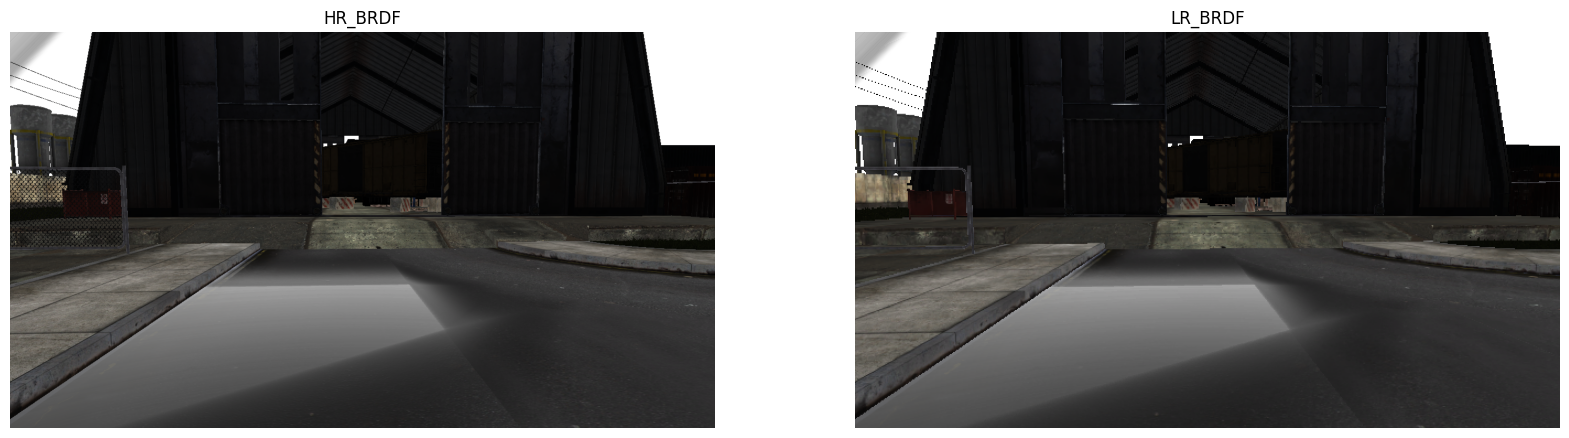

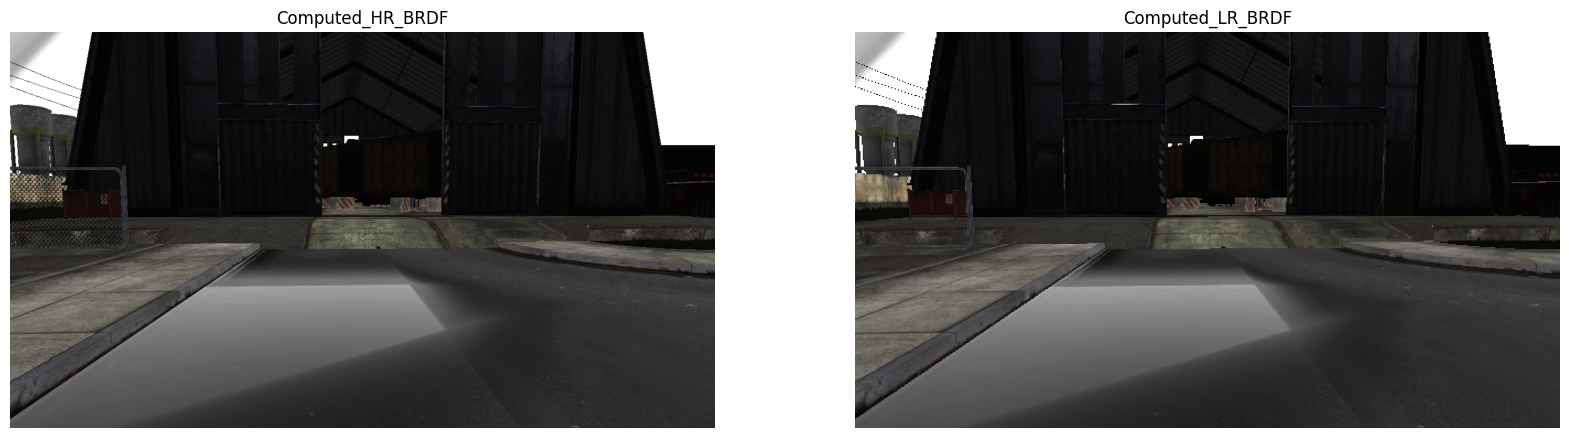

In [63]:
brdf_hr = compute_brdf(hr_albedo, hr_roughness, hr_metallic, hr_specular, hr_nov, precomp)
brdf_lr = compute_brdf(lr_albedo, lr_roughness, lr_metallic, lr_specular, lr_nov, precomp)
brdf_hr_comp = compute_brdf(albedo_computed_hr, hr_roughness, hr_metallic, hr_specular, hr_nov, precomp)
brdf_lr_comp = compute_brdf(albedo_computed_lr, lr_roughness, lr_metallic, lr_specular, lr_nov, precomp)

# Display the BRDF
ImageUtils.display_images([brdf_hr, brdf_lr], ['HR_BRDF', 'LR_BRDF'])
ImageUtils.display_images([brdf_hr_comp, brdf_lr_comp], ['Computed_HR_BRDF', 'Computed_LR_BRDF'])

tensor(0.) tensor(1.0080)
tensor(0.) tensor(1.0002)


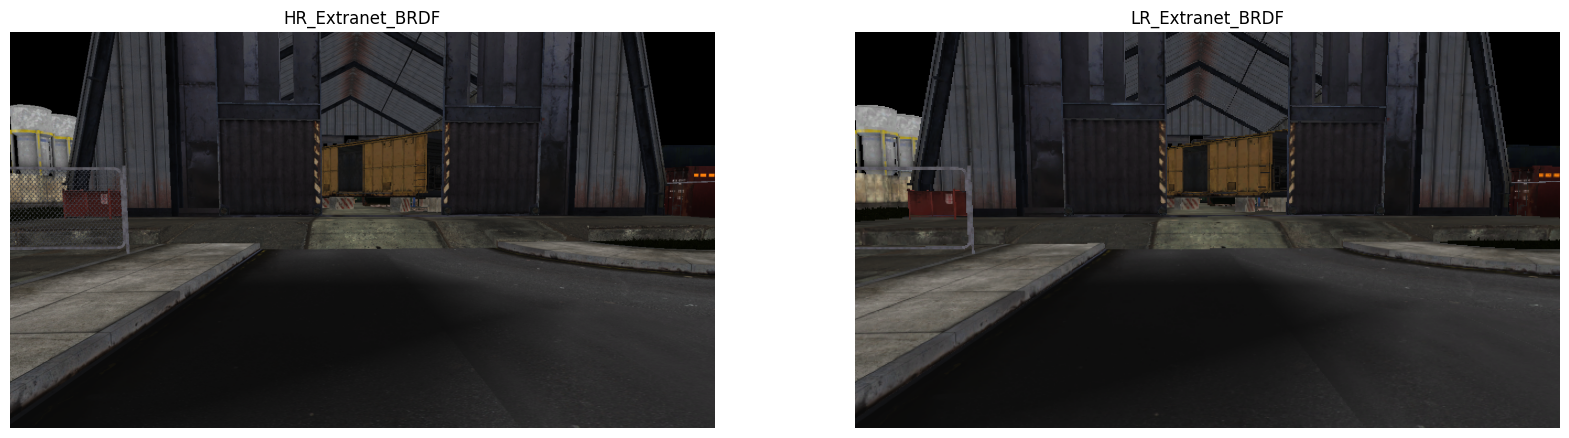

In [64]:
extranet_brdf_hr = compute_brdf_extranet(hr_base_color, hr_specular, hr_metallic)
extranet_brdf_lr = compute_brdf_extranet(lr_base_color, lr_specular, lr_metallic)

print(extranet_brdf_hr.min(), extranet_brdf_hr.max())
print(extranet_brdf_lr.min(), extranet_brdf_lr.max())

# Display the BRDF
ImageUtils.display_images([extranet_brdf_hr, extranet_brdf_lr], ['HR_Extranet_BRDF', 'LR_Extranet_BRDF'])

In [65]:
# Choose the brdf map
brdf_map_hr = extranet_brdf_hr
brdf_map_lr = extranet_brdf_lr

tensor(0.) tensor(16.0074)
tensor(0.) tensor(13.1706)


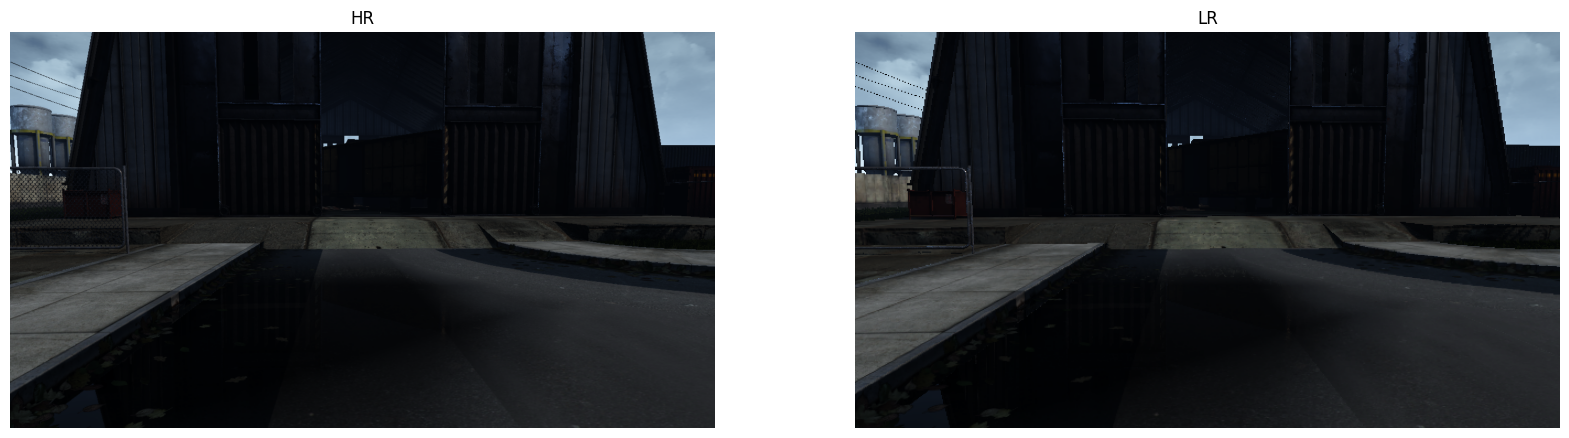

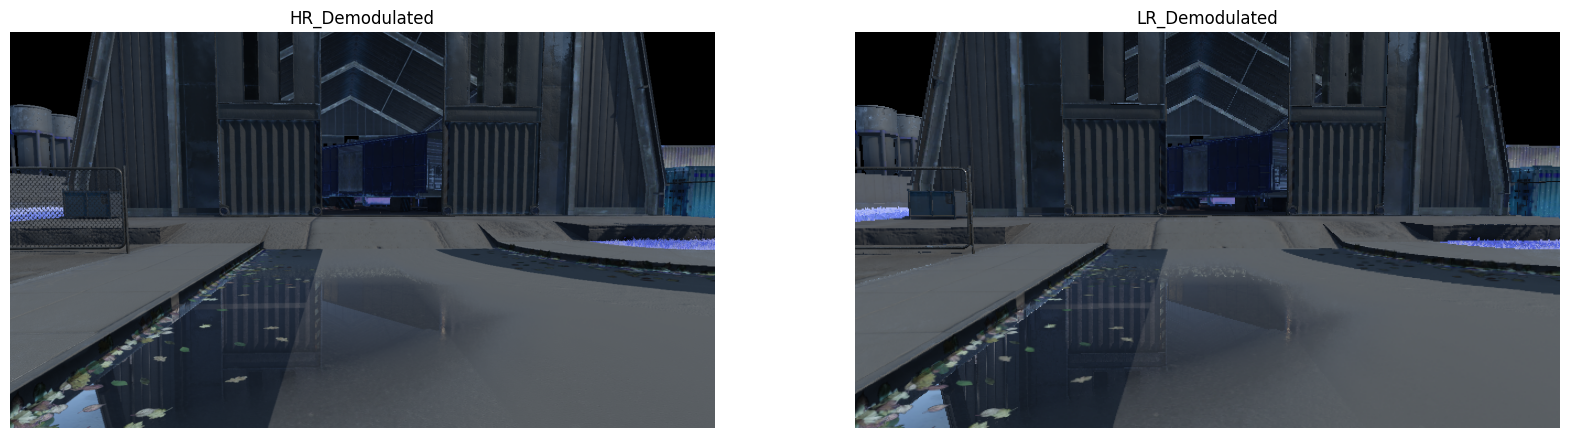

In [66]:
demodulated_hr = brdf_demodulate(pre_tonemapped_hr, brdf_map_hr)
demodulated_lr = brdf_demodulate(pre_tonemapped_lr, brdf_map_lr)

print(demodulated_hr.min(), demodulated_hr.max())
print(demodulated_lr.min(), demodulated_lr.max())

# Display the demodulated frames
demodulated_hr_norm = exp.normalize(demodulated_hr * 0.5)
demodulated_lr_norm = exp.normalize(demodulated_lr * 0.5)

# Display the pre-tonemapped frames
ImageUtils.display_images([pre_tonemapped_hr_exp, pre_tonemapped_lr_exp], ['HR', 'LR'])
ImageUtils.display_images([demodulated_hr_norm, demodulated_lr_norm], ['HR_Demodulated', 'LR_Demodulated'])

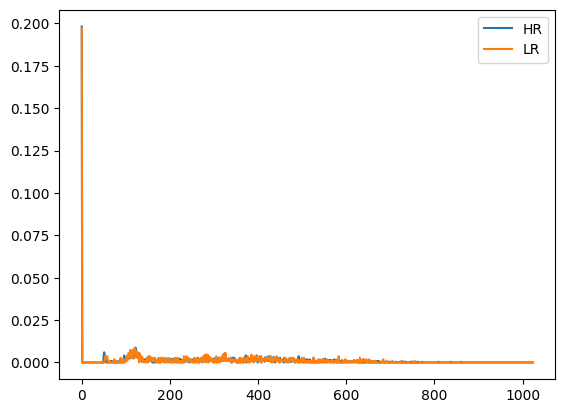

In [67]:
import cv2
import numpy as np
# Plot histogram of the demodulated frames
# Use opencv to compute the histogram
hist_hr = cv2.calcHist([demodulated_hr.cpu().numpy()], [0], None, [1024], [0, 1])
hist_lr = cv2.calcHist([demodulated_lr.cpu().numpy()], [0], None, [1024], [0, 1])
hist_hr = hist_hr / hist_hr.sum()
hist_lr = hist_lr / hist_lr.sum()

# Plot the histogram
import matplotlib.pyplot as plt
plt.plot(hist_hr, label='HR')
plt.plot(hist_lr, label='LR')
plt.legend()

# Display the histogram
plt.show()

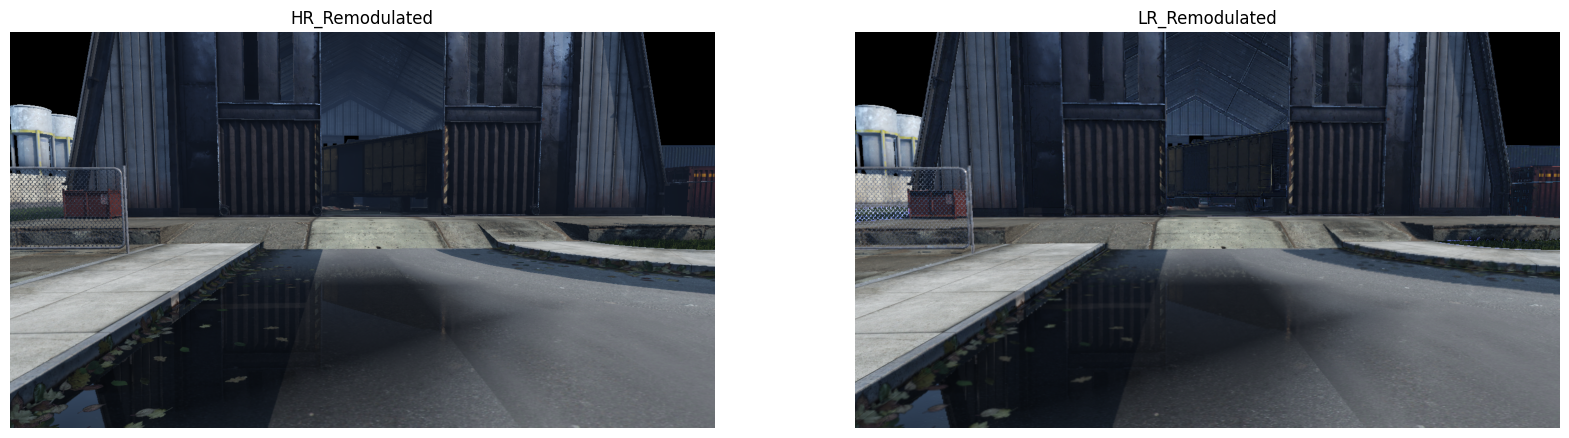

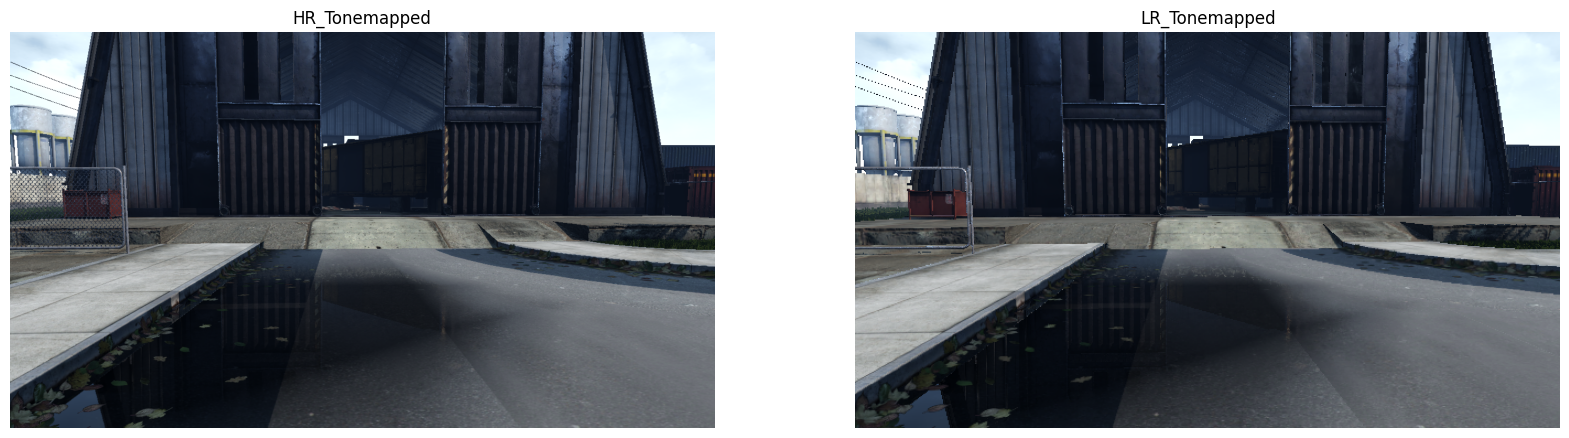

In [68]:
# Upsample demodulated lr
demodulated_lr_up = ImageUtils.upsample(demodulated_lr.unsqueeze(0), 2.0).squeeze(0)

# Remodulate the frames
remodulated_hr = brdf_remodulate(demodulated_hr, brdf_map_hr)
remodulated_lr_up = brdf_remodulate(demodulated_lr_up, brdf_map_hr)
remodulated_lr = brdf_remodulate(demodulated_lr, brdf_map_lr)

# Tonemap
remodulated_hr_tonemapped = tonemapper(remodulated_hr)
remodulated_lr_up_tonemapped = tonemapper(remodulated_lr_up)
remodulated_lr_tonemapped = tonemapper(remodulated_lr)

# Display the remodulated frames
ImageUtils.display_images([remodulated_hr_tonemapped, remodulated_lr_up_tonemapped], ['HR_Remodulated', 'LR_Remodulated'])
ImageUtils.display_images([tonemapped_hr, tonemapped_lr], ['HR_Tonemapped', 'LR_Tonemapped'])

In [69]:
# Compute scores
psnr_rm = ImageEvaluator.psnr(remodulated_hr_tonemapped, remodulated_lr_up_tonemapped, 1.0)
ssim_rm = ImageEvaluator.ssim(remodulated_hr_tonemapped.unsqueeze(0), remodulated_lr_up_tonemapped.unsqueeze(0))
mse_rm = ImageEvaluator.mse(remodulated_hr_tonemapped, remodulated_lr_up_tonemapped)
lpips_rm = ImageEvaluator.lpips(remodulated_hr_tonemapped, remodulated_lr_up_tonemapped)

# Display the scores
print(f'Metric,  Remodulated')
print(f'PSNR,    {psnr_rm.item():.2f}')
print(f'SSIM,    {ssim_rm.item():.4f}')
print(f'MSE,     {mse_rm.item():.4f}')
print(f'LPIPS,   {lpips_rm.item():.4f}')

Metric,  Remodulated
PSNR,    29.70
SSIM,    0.9043
MSE,     0.0011
LPIPS,   0.1425


In [70]:
# Compute scores for bilinear upsampling
tonemapped_lr_up_bilinear = ImageUtils.upsample(remodulated_lr_tonemapped.unsqueeze(0), 2.0, 'bilinear').squeeze(0)

# Compute scores
psnr_bilinear = ImageEvaluator.psnr(remodulated_hr_tonemapped, tonemapped_lr_up_bilinear, 1.0)
ssim_bilinear = ImageEvaluator.ssim(remodulated_hr_tonemapped.unsqueeze(0), tonemapped_lr_up_bilinear.unsqueeze(0))
mse_bilinear = ImageEvaluator.mse(remodulated_hr_tonemapped, tonemapped_lr_up_bilinear)
lpips_bilinear = ImageEvaluator.lpips(remodulated_hr_tonemapped, tonemapped_lr_up_bilinear)

# Display the scores
print(f'Metric,  Bilinear')
print(f'PSNR,    {psnr_bilinear.item():.2f}')
print(f'SSIM,    {ssim_bilinear.item():.4f}')
print(f'MSE,     {mse_bilinear.item():.4f}')
print(f'LPIPS,   {lpips_bilinear.item():.4f}')

Metric,  Bilinear
PSNR,    29.49
SSIM,    0.8722
MSE,     0.0011
LPIPS,   0.2489
